<a href="https://colab.research.google.com/github/Jibbie17/xray/blob/main/xray_vision_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team: X-Ray Vision
Group Members:
- Gabriel Barrett
- Ruben Gallardo
- Zewei (Whiskey) Liao

# Set-Up

## Local Set-Up

In [1]:
from pathlib import Path
from PIL import Image
import pandas as pd
import json
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
import re
from sklearn.model_selection import train_test_split
import logging
import pickle
import lightning as L

# Set up logging to file and console
logging.basicConfig(
    level = logging.INFO,
    format = '%(asctime)s:%(levelname)s:%(message)s',
    handlers = [logging.FileHandler("xray-cnn.log"),
              logging.StreamHandler()])

In [3]:
cwd = os.getcwd()
# data_folder_path = '/Users/rubengallardo/Documents/GitHub/Spring_2024/ml_project/data-pooled-for-resplit/'

data_folder_path = cwd + '/data/'
data_csv_path = data_folder_path + "data.csv"
aug_data_csv_path = data_folder_path + "data_aug.csv"

# [Run Once] Resplit the Dataset 

In [3]:
Image_Stats = namedtuple('Image_Stats', ["label", "image_name", "path"])

def construct_df(data_folder_path):
    '''
    Pull the label, file name, and file path of each image and compile into a df
    for later re-spliting.
    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []

    # loop over the only two options of subfolders: NORMAL or PNEUMONIA
    for folder_name in ["NORMAL", "PNEUMONIA"]:
      folder_path = os.path.join(data_folder_path, folder_name)

      # loop over each x-ray image file
      for file_name in os.listdir(folder_path):
        if file_name == '.DS_Store':
          continue
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
          img_label = 1 if folder_name == 'PNEUMONIA' else 0
          # compile into a tuple for each image
          tup = Image_Stats(img_label, file_name, file_path)
          tup_list.append(tup)

    return tup_list

tup_list = construct_df(data_folder_path)
df_before_resplit = pd.DataFrame(tup_list).reset_index()

# RESPLIT
# Splitting data into train and temp (temp will be split into validation and test)
train, temp = train_test_split(
  df_before_resplit, test_size=0.3, 
  stratify=df_before_resplit['label'], random_state=42)

# Splitting temp into validation and test
valid, test = train_test_split(temp, test_size=(2/3), stratify=temp['label'], random_state=42)

# Assigning split labels
train['split'] = 'train'
valid['split'] = 'valid'
test['split'] = 'test'

# Combining the splits back into a single DataFrame
df_resplit = pd.concat([train, valid, test])

# Verifying the splits
print(df_resplit['split'].value_counts())

# create two copies of the normal training data
normal_train_images = df_resplit.loc[(df_resplit['label'] == 0) & (df_resplit['split'] == 'train')]
# add these copies to our training dataset to help with the class imbalance problem
df_aug = pd.concat([df_resplit, normal_train_images, normal_train_images]).reset_index(drop=True)

# save it to a new path
df_aug.to_csv(aug_data_csv_path, index = False)
print(df_aug['split'].value_counts())

split
train    4099
test     1172
valid     585
Name: count, dtype: int64
split
train    6315
test     1172
valid     585
Name: count, dtype: int64


# [Don't Run] Pre-Processing & Summary Stats 

In [ ]:
Image_Stats = namedtuple('Image_Stats', ["split", "label", "sick_type", "width", "height", "pixels_sq", "ratio", "channels", "image_name", "path"])

METRICS = ["widths", "heights", "pixels_sq", "ratios", "channels"]

def compile_stats(data_path):
    '''
    This function takes a path that specifies the root directory where the
    data folders are located, finds each file and saves each file's
    reference information in a named tuple called "Image_Stats." This function
    then returns a list of the named tuples and a dicitonary of summary statistics
    that summarizes statistics for all of the tuples.

    Takes: data_path (str), a string specifying the root of the directory where
    the path is located.

    Returns:

    '''
    # a list of tuples for later conversion into pandas df
    tup_list = []
    sum_stats = {}

    # iterate through the level 1 folders -- test, train, and val
    for folder_l1 in os.listdir(data_path):
        # ignore the irrelevant doc / folders
        if folder_l1 in ('.DS_Store', '__MACOSX'):
            continue
        fl1 = os.path.join(data_path, folder_l1)

        # checking if it is a folder
        if not os.path.isdir(fl1):
            continue
        sum_stats[folder_l1] = {}
        for folder_l2 in os.listdir(fl1):
            # iterating through Normal and Pnemonia
            if folder_l2 == '.DS_Store':
                continue
            fl2 = os.path.join(fl1, folder_l2)
            if not os.path.isdir(fl2):
                continue
            sum_stats[folder_l1][folder_l2] = {}

            for filename in os.listdir(fl2):
                # iterating through images
                if filename == '.DS_Store':
                    continue
                f = os.path.join(fl2, filename)
                # checking if it is a file
                if not os.path.isfile(f):
                    continue

                image_obj = Image.open(f)

                #initializing empty lists of summary statistics
                for m in METRICS:
                    sum_stats[folder_l1][folder_l2][m] = sum_stats[folder_l1][folder_l2].get(m, [])

                #fillin in the summary statistics
                sum_stats[folder_l1][folder_l2]["widths"].append(image_obj.width)
                sum_stats[folder_l1][folder_l2]["heights"].append(image_obj.height)

                #calculating square pixels
                square_pixels = int(image_obj.height) * int(image_obj.width)
                sum_stats[folder_l1][folder_l2]["pixels_sq"].append(square_pixels)

                ratio = int(image_obj.width)/int(image_obj.height)
                sum_stats[folder_l1][folder_l2]["ratios"].append(ratio)

                #counting the number of layers / channels
                channels = image_obj.getbands()
                sum_stats[folder_l1][folder_l2]["channels"].append(len(channels))

                img_label = 1 if folder_l2 == 'PNEUMONIA' else 0

                # Checking if the Label is Bacteria or Virus
                if folder_l2 == 'PNEUMONIA':
                    str_path = str(filename)
                    if re.search("virus", str_path):
                        sick = "Virus"
                    else:
                        sick = "Bacteria"
                else:
                    sick = "Normal"

                tup = Image_Stats(folder_l1, img_label, sick, image_obj.width, image_obj.height, square_pixels, ratio, len(channels), filename, f)
                tup_list.append(tup)

                del image_obj

    return sum_stats, tup_list

In [ ]:
dic, tup_list = compile_stats(data_folder_path)
df = pd.DataFrame(tup_list)

# Verify DataFrame
df.head(10)

In [ ]:
# reload the data df
df = pd.read_csv(data_csv_path)
df.head(5)

In [ ]:
# save
df.to_csv(data_csv_path, index = False)

In [ ]:
df["ratio"].mean()

#Presenting the averages for each summary statistic.

df[["width", "height", "ratio", "channels"]].mean()

In [ ]:
# Ploting the distributing of each summary statistic.
df[["width", "height", "ratio", "channels"]].hist()

Based on these summary statistics the vast majority of images are landscape, meaning that the width is longer than the height. Almost all the images have only one channel, meaning they are in greyscale, but it appears 283 images have three channels meaning their data is held in rgb.

In [ ]:
df_channels = df[["channels"]]
df_channels[df[["channels"]]==3].count()

# Implement Custom Dataset & Augmentations

In [4]:
df = pd.read_csv(aug_data_csv_path)

We implemented a custom Dataset class based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files). This class will help us do our image augmentations later on.

In [5]:
# Custom PyTorch Image Dataset Class
# Code Resource: https://pytorch.org/tutorials/beginner/basics/data_tutreadorial.html#creating-a-custom-dataset-for-your-files

# inheriting from the pytorch Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, df, transform = None):
        """
        df (pandas df): pandas dataframe
        split: "train", "valid", or "test"
        transform: Compose (a PyTorch Class) that strings together several
        transform functions (e.g. data augmentation steps)
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        img_path = Path(self.df.loc[idx, 'path'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']

        # Image Transformation
        if self.transform:
            image = self.transform(image)

        # Returns augmented and/or normalized image with label
        return image, label

In [6]:
# Augmentation for Training Data
# The augmentations below are the new ones that I took from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8330434/
augmentations = T.Compose([
    T.Resize((256, 256)),

    # every image has 50/50 chance of being flipped horizontally
    T.RandomHorizontalFlip(p=0.5),

    # every image will be rescaled and cropped, but how it gets rescaled and cropped will be random
    # scale param defines the range of the area of the image to be used in the crop.
    # (scale = 0.8, 1.0) means the cropped area will be at least 80% to 100% of the image area
    # ratio param defines the range of aspect ratios for the cropped area
    # 0.75 means the aspect ratio (width/height) can be as low as 3:4
    # 1.33 means the aspect ratio (width/height) can be as high as 4:3
    T.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # The brightness and contrast of every image will be randomly changed
    # brightness=0.2 means the brightness factor is chosen randomly from the range [0.8, 1.2]
    # contrast=0.2 means the contrast factor is chosen randomly from the range [0.8, 1.2]
    T.ColorJitter(brightness=0.2, contrast=0.2),

    # All images are rotated by a random angle within the range [-10, 10]
    # Notice that 0 is included in the range, which means some images will NOT be rotated
    T.RandomRotation(degrees=10), # Random rotation

    # RandomApply applies a list of transformations randomly based on the given probability (p=0.5)
    # kernel_size=(5,5): This specifies the size of the Gaussian kernel. In this case, the kernel is a 5x5 matrix.
    # sigma=(0.1, 0.2): This specifies the range of standard deviation for the Gaussian kernel.
    # The actual standard deviation used for blurring is chosen randomly from the range [0.1, 0.2]
    T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),

    # The two transformations below make the images compatible with the dataloader and model
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()  # Convert images to tensors
])

# Normalization for Validation and Test datasets
normalizations = T.Compose([
    T.Resize((256, 256)),
    T.Grayscale(num_output_channels=1),  # Convert images to grayscale
    T.ToTensor()
])

# Split, Summarize, Load Data

After extracting the summary statistics of our images and storing them in a DataFrame, we prepared the data for the DataLoader by separating out the summary statistic into a training, test, and validation DataFrame. We also created a table that shows how many images fall into the normal or pneumonia group for each dataset.

In [7]:
# Creating separate DataFrame's for the training, validation, and test set
test_df = df.loc[df.loc[:, 'split'] == 'test']
train_df = df.loc[df.loc[:, 'split']=='train']
valid_df = df.loc[df.loc[:, 'split'] == 'valid']

# Count the occurrences of each label
train_counts = train_df['label'].value_counts().sort_index()
val_counts = valid_df['label'].value_counts().sort_index()
test_counts = test_df['label'].value_counts().sort_index()

# Prepare Data for summary table
summary_data = {
    'Normal': [train_counts.get(0, 0), val_counts.get(0, 0), test_counts.get(0, 0)],
    'Pneumonia': [train_counts.get(1, 0), val_counts.get(1, 0), test_counts.get(1, 0)]
}

# Create a summary table
summary_df = pd.DataFrame(summary_data, index=['Train', 'Validation', 'Test'])
summary_df

,Normal,Pneumonia
Train,3324,2991
Validation,158,427
Test,317,855


## Implement Data Loader

Based on [this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders), we passed each dataset to a DataLoader. As the documentation states, this will help us pass random mini-batches of the data to our model.

In [8]:
# Creating a CustomImageDataset object for each dataset
train_data = CustomImageDataset(train_df, augmentations) # changed parameter from augmentations to old_augmentations
valid_data = CustomImageDataset(valid_df, normalizations)
test_data = CustomImageDataset(test_df, normalizations)

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Building the Neural Network

In [9]:
import torch
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

## [IGNORE] Pickle

In [11]:
result_dict = {
    "train_losses": train_losses, "train_accuracies": train_accuracies,
    "val_losses": val_losses, "val_accuracies": val_accuracies
}

# Serializing the object (saving to a file)
with open('pickle_test.pkl', 'wb') as file:
    pickle.dump(result_dict, file)

NameError: name 'train_losses' is not defined

## [OLD CODE from May 17] Lightening

The following section refactors the previous code into a OOP framework using PyTorch Lightening.

In [ ]:
class CNN_L(L.LightningModule):
  '''
  inspire by Turing award winning LeCun, Bengio and Hinton's paper from 1998
  https://ieeexplore.ieee.org/document/726791 (cited more than 25,000 times!!!!!!!!!)
  code from https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
  '''
  def __init__(self, lr = 0.001, loss_fn = nn.CrossEntropyLoss()):
    '''
    TODO: hyperparameters:
    - learning rate
    - loss function (criteria)
    '''
    super(CNN_L, self).__init__()
    self.lr = lr # learning rate
    self.loss_fn = loss_fn # loss function
    # The attributes below let us save all of the predictions and actual labels in the class
    # when we are ready to evaluate. These are set in predict_all as numpy arrays.
    # objects.
    self.predictions = None
    self.y = None
    # The y_score is the "predicted probability" as opposed to the prediciton
    # This is needed for the ROC-AUC curve
    self.y_score = None
    # We will save our metrics in a dictionary. The dictioary will be filled on a
    # call to evaluate_model ()
    self.metrics = {}

    self.LeNet = nn.Sequential(
        # convolutional layers
        nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
          nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride= 1, padding = 0),    # CONVOLUTION
          # Matches the number of output channels from the previous layer.
          # This normalizes the output from the convolution layer, stabilizing the learning process.
          nn.BatchNorm2d(num_features = 6),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
        nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
          nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),   # CONVOLUTION
          nn.BatchNorm2d(num_features = 16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
        # fully connected layers
        nn.Flatten(),
        nn.Linear(in_features = 59536, out_features = 120),                                   # THIRD LAYER: LINEAR YEAR, HIDDEN LAYER 2
        nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
        nn.Linear(in_features = 120, out_features = 84),                                       # FOURTH LAYER: LINEAR YEAR, HIDDEN LAYER 3
        nn.ReLU(),                                                # HIDDEN LAYER's ACTIVATION FUNCION
        # output layer
        nn.Linear(in_features = 84, out_features = 2)                                          # OUTPUT LAYER
    )

  def training_step(self, batch, batch_idx):
    '''
    This is an inherited method from LightningModule, do not change its name.
    
    Parameters:
    - batch: The output of your data iterable, normally a DataLoader.
    - batch_idx: The index of this batch.
    '''
    logging.debug(f"currently at {batch_idx}-th batch")
    inputs, labels = batch
    outputs = self(inputs)
    loss = self.loss_fn(outputs, labels)  
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    logging.debug(f"prediction = {predicted}, acc = {acc}")
    self.log('train_loss', loss, prog_bar=True)
    self.log('train_acc', acc, prog_bar=True)
    
    return loss

  def validation_step(self, batch, batch_idx):
    inputs, labels = batch
    outputs = self(inputs)
    loss = self.loss_fn(outputs, labels)
    
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc', acc, prog_bar=True)

    return loss
  
  def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

  def configure_optimizers(self):
    '''
    This is an inherited method from LightningModule, do not change its name.
    '''
    optimizer = optim.SGD(self.parameters(), lr = self.lr, momentum=0.9)
    return optimizer

  def forward(self, x):
    out = self.LeNet(x)
    # logging.debug(f"Input shape: {x.shape}, Output shape: {out.shape}")
    return out

  def confusion_matrix(self):
    cm = confusion_matrix(self.y, self.predictions)
    ConfusionMatrixDisplay(cm).plot()

  def roc_curve(self):
    # This function returns an roc curve, which graphs the false positive
    # and true positive rate.
    if self.y is None or self.predictions is None:
      self.predict_all()
    false_pos_rate, true_pos_rate, thresholds = roc_curve(self.y, self.predictions)
    # Plot the curve
    plt.plot(false_pos_rate, true_pos_rate)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

  def evaluate_model(self, re_test = False):
    '''
    '''
    if self.predictions is None or self.y is None or re_test is True:
      self.predict_all()
    # calculate accuracy
    total_tests = len(self.y)
    got_right = np.sum((self.y == self.predictions))
    acc = got_right/total_tests
    self.metrics["accuracy"] = acc
    # calculate recall
    recall = recall_score(self.predictions, self.y)
    self.metrics["recall"] = recall
    # area under the roc curve
    self.metrics["auc_roc"] = roc_auc_score(self.predictions,self.y)


  def predict_all(self, data_loader):
      self.train()
      beta_list = []
      y_list= []
      y_score_list = []
      for i, data in enumerate(data_loader):
        x, y = data
        outputs = self(x)
        max_value, predicted = torch.max(outputs.data, 1)
        y_list.append(y)
        beta_list.append(predicted)
      # We combine each lists (predictions and label) then convert them
      # to numpy arrays
      self.predictions = torch.cat(beta_list, dim = 0).detach().cpu().numpy()
      self.y = torch.cat(y_list, dim = 0).detach().cpu().numpy()

In [ ]:
cnn = CNN_L()
trainer = L.Trainer(max_epochs=5)
trainer.fit(model=cnn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
trainer.test(model=cnn, dataloaders=val_dataloader)

# [!LATEST] Lightening w/Graphs

In [10]:
from pytorch_lightning.callbacks import Callback
import pytorch_lightning as pl # pytorch_lightning & Lightning are supposed to be the same

class MetricLogger(Callback):
    def __init__(self):
        super(MetricLogger, self).__init__()  # Ensure the parent class is initialized
        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
        self.recall = []
        self.auc_roc = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_acc = trainer.callback_metrics.get('train_acc')
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_acc is not None:
            self.train_acc.append(train_acc.item())
        if train_loss is not None:
            self.train_loss.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.sanity_checking:
            return  # Skip logging during the sanity check
        val_acc = trainer.callback_metrics.get('val_acc')
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_acc is not None:
            self.val_acc.append(val_acc.item())
        if val_loss is not None:
            self.val_loss.append(val_loss.item())

        # Calculate additional metrics
        val_preds = []
        val_labels = []
        device = next(trainer.model.parameters()).device
        for batch in trainer.val_dataloaders:
            x, y = batch
            x, y = x.to(device), y.to(device)
            preds = trainer.model(x)
            _, predicted = torch.max(preds, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(y.cpu().numpy())
        
        recall = recall_score(val_labels, val_preds, average='macro')
        auc_roc = roc_auc_score(val_labels, val_preds, multi_class='ovr')
        self.recall.append(recall)
        self.auc_roc.append(auc_roc)
    
    def reset_metrics(self):
        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []
        self.recall = []
        self.auc_roc = []

class CNN_L(pl.LightningModule):
    def __init__(self, lr=0.001, loss_fn=nn.CrossEntropyLoss()):
        super(CNN_L, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.loss_fn = loss_fn
        self.predictions = None
        self.y = None
        self.y_score = None
        self.metrics = {}

        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(num_features=6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)),
            nn.Sequential(
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(num_features=16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)),
            nn.Flatten(),
            nn.Linear(in_features=59536, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=2)
        )

    def training_step(self, batch, batch_idx):
        '''
        This is an inherited method from LightningModule, do not change its name.
    
        Parameters:
            - batch: The output of your data iterable, normally a DataLoader.
            - batch_idx: The index of this batch.
        '''
        logging.debug(f"currently at {batch_idx}-th batch")
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, labels)  
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        logging.debug(f"prediction = {predicted}, acc = {acc}")
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
    
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, labels)
    
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
    
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return loss

    def configure_optimizers(self):
        '''
        This is an inherited method from LightningModule, do not change its name.
        '''
        optimizer = optim.SGD(self.parameters(), lr = self.lr, momentum=0.9)
        return optimizer

    def forward(self, x):
        out = self.LeNet(x)

        # logging.debug(f"Input shape: {x.shape}, Output shape: {out.shape}")
        return out

In [12]:
def run_model_for_hyperparams(epochs, hyperparams_list, train_dataloader, val_dataloader):
    '''
    Run a series of models given different hyperparameters.

    Input:
    - hyperparams_list: hyperparams to train on in a list of dict, e.g. `[{'lr': 0.001}, {'lr': 0.01}]`
    '''
    # results to be returned at the end
    results = {
        'train_acc': {},
        'val_acc': {},
        'train_loss': {},
        'val_loss': {},
        'recall': {},
        'auc_roc': {}
    }
    
    # iterate over each hyperparam in the list
    for hyperparams in hyperparams_list:
        metric_logger = MetricLogger()
        metric_logger.reset_metrics()
        # `hyperparams` is a dict e.g. {'lr': 0.001}
        cnn = CNN_L(lr = hyperparams['lr'])
        
        trainer = pl.Trainer(max_epochs = epochs, callbacks = [metric_logger], 
                             num_sanity_val_steps = 0, devices = 'auto')
        trainer.fit(model=cnn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
        
        key = f"lr_{hyperparams['lr']}"
        results['train_acc'][key] = [0] + metric_logger.train_acc  # Add initial data point at epoch 0
        results['val_acc'][key] = [0] + metric_logger.val_acc    
        results['train_loss'][key] = [0] + metric_logger.train_loss 
        results['val_loss'][key] = [0] + metric_logger.val_loss    
        results['recall'][key] = [0] + metric_logger.recall         
        results['auc_roc'][key] = [0] + metric_logger.auc_roc 
            
    return results

In [13]:
# Test Run w/ Different Learning Rates
# hyperparams_list = [{'lr': 0.001}, {'lr': 0.01}]
hyperparams_list = [{'lr': 0.001}]
num_epochs = 4 # TODO: CHANGE THE MAX NUM OF EPOCHS HERE!
results = run_model_for_hyperparams(num_epochs, hyperparams_list, train_dataloader, val_dataloader)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
2024-05-18 15:44:20,622:INFO:GPU available: False, used: False
2024-05-18 15:44:20,630:INFO:TPU available: False, using: 0 TPU cores
2024-05-18 15:44:20,632:INFO:IPU available: False, using: 0 IPUs
2024-05-18 15:44:20,634:INFO:HPU available: False, using: 0 HPUs
2024-05-18 15:44:20,671:INFO:
  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | LeNet   | Sequential       | 7.2 M 
---------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.630    Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2024-05-18 16:07:57,992:INFO:`Trainer.fit` stopped: `max_epochs=4` reached.


## Plot the results

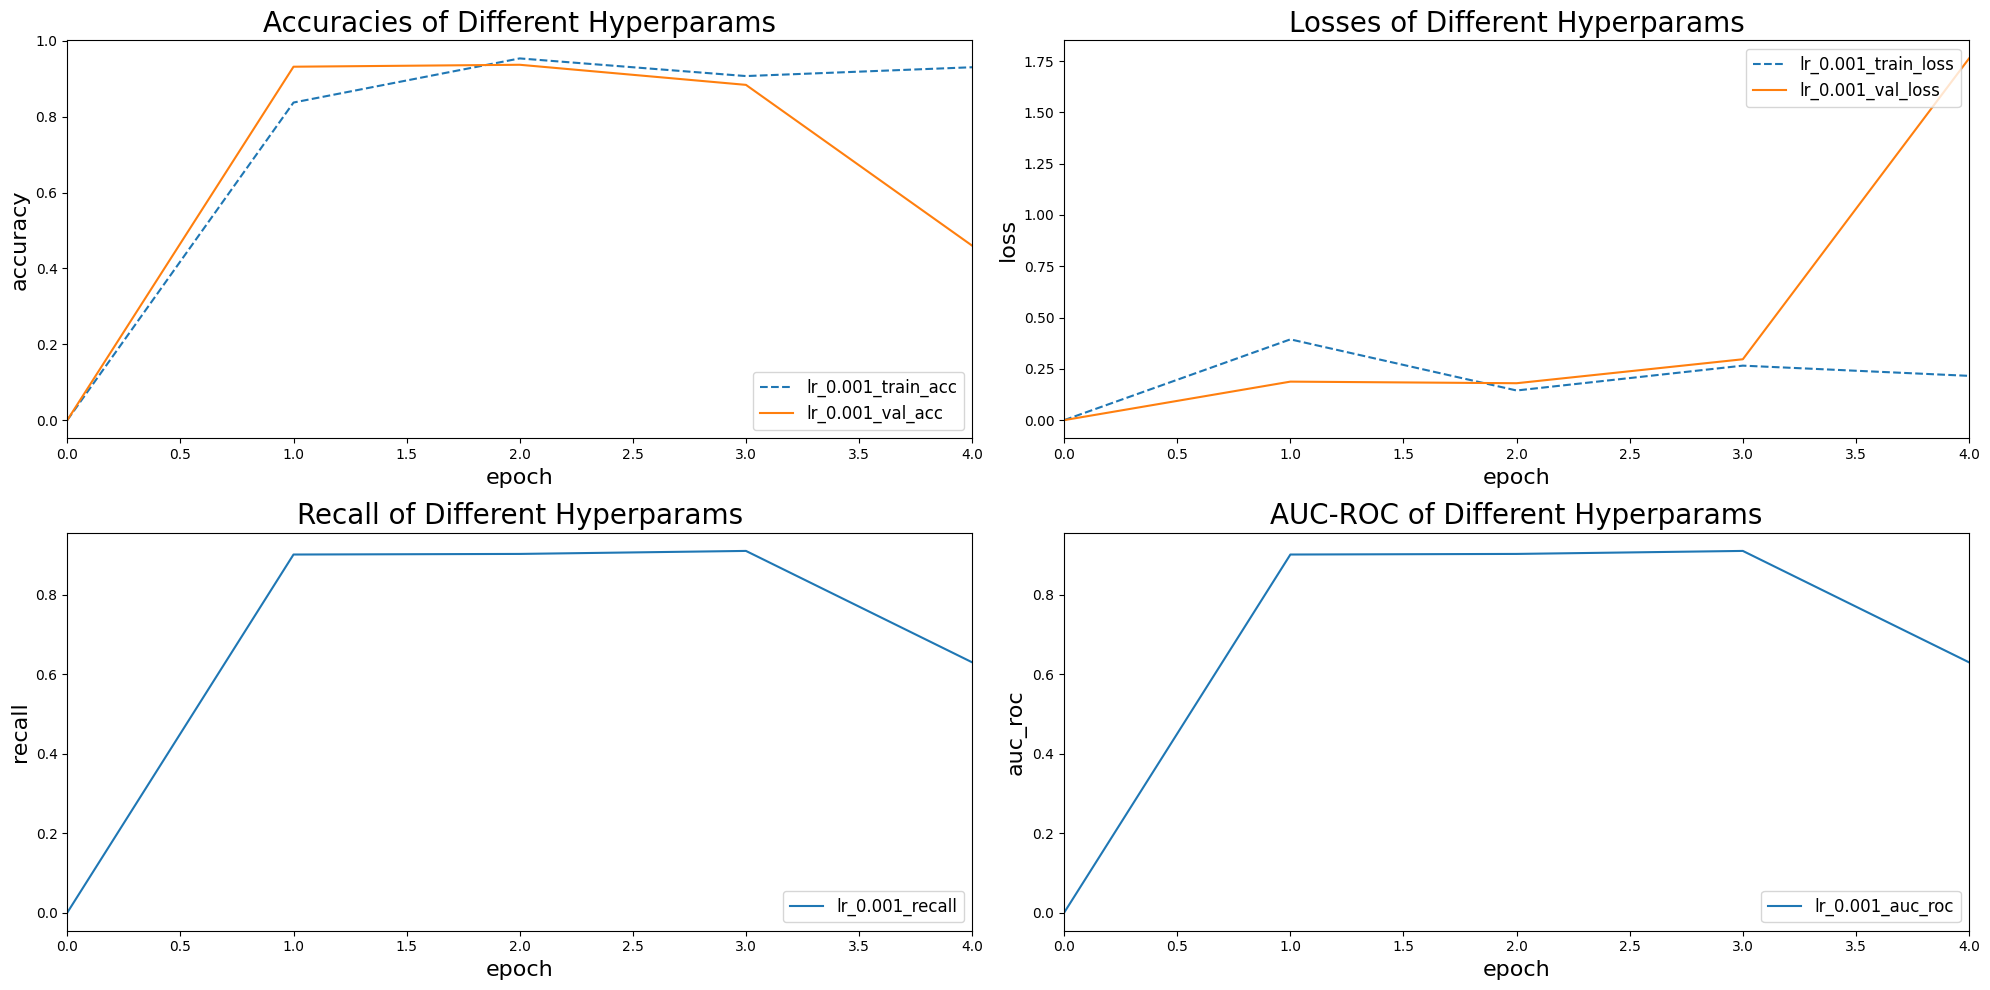

In [17]:
# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot Accuracy
for key in results['train_acc']:    
    epochs = [i for i in range(0, num_epochs + 1)]
    axes[0, 0].plot(epochs, results['train_acc'][key], label=f'{key}_train_acc', linestyle='dashed')
    axes[0, 0].plot(epochs, results['val_acc'][key], label=f'{key}_val_acc', linestyle='solid')

axes[0, 0].set_title('Accuracies of Different Hyperparams', fontsize=20)
axes[0, 0].legend(loc="lower right", fontsize=12)
axes[0, 0].set_xlabel("epoch", fontsize=16)
axes[0, 0].set_ylabel("accuracy", fontsize=16)
axes[0, 0].set_xlim(0, num_epochs)  # Set x-axis limits to start from 0

# Plot Loss
for key in results['train_loss']:
    epochs = [i for i in range(0, num_epochs + 1)]
    axes[0, 1].plot(epochs, results['train_loss'][key], label=f'{key}_train_loss', linestyle='dashed')
    axes[0, 1].plot(epochs, results['val_loss'][key], label=f'{key}_val_loss', linestyle='solid')

axes[0, 1].set_title('Losses of Different Hyperparams', fontsize=20)
axes[0, 1].legend(loc="upper right", fontsize=12)
axes[0, 1].set_xlabel("epoch", fontsize=16)
axes[0, 1].set_ylabel("loss", fontsize=16)
axes[0, 1].set_xlim(0, num_epochs) 

# Plot Recall
for key in results['recall']:
    epochs = [i for i in range(0, num_epochs + 1)]
    axes[1, 0].plot(epochs, results['recall'][key], label=f'{key}_recall', linestyle='solid')

axes[1, 0].set_title('Recall of Different Hyperparams', fontsize=20)
axes[1, 0].legend(loc="lower right", fontsize=12)
axes[1, 0].set_xlabel("epoch", fontsize=16)
axes[1, 0].set_ylabel("recall", fontsize=16)
axes[1, 0].set_xlim(0, num_epochs) 

# Plot AUC-ROC
for key in results['auc_roc']:
    epochs = [i for i in range(0, num_epochs + 1)]
    axes[1, 1].plot(epochs, results['auc_roc'][key], label=f'{key}_auc_roc', linestyle='solid')

axes[1, 1].set_title('AUC-ROC of Different Hyperparams', fontsize=20)
axes[1, 1].legend(loc="lower right", fontsize=12)
axes[1, 1].set_xlabel("epoch", fontsize=16)
axes[1, 1].set_ylabel("auc_roc", fontsize=16)
axes[1, 1].set_xlim(0, num_epochs)

plt.tight_layout()
plt.show()